**Author:** Rupa Ghosh <br />
**About this File:** This code processes images from two different data folders, prepares the data into arrays and then processes Evidently data drift modes to check if there is data drift. <br />
**Overview of the File:** <br />
1. Create data sets in two different folders.
2. Load images from the folders, process them and create dataframes.
3. Load Evidently DataDrift components.
4. Run the DataDrift process and create dashboards.
5. Performed these steps for two sets of pictures
    Sugar Beet with Sugar Beet showed almost no shift detection
    Sugar Beet with Shepherds Purse pictures showed shift in almost all the features of the images.
    




## Map Google drive and Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [2]:
%matplotlib inline
import json
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from random import randrange
import cv2

In [3]:
! pip install evidently

     |████████████████████████████████| 13.3 MB 226 kB/s 


In [4]:
import pandas as pd
from sklearn import datasets

from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab
from evidently.model_profile import Profile
from evidently.profile_sections import DataDriftProfileSection


In [8]:
!pip install mlflow

In [9]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

In [10]:
import plotly.offline as py #working offline
import plotly.graph_objs as go

## Load Images Data.
#### Lets prepare the the classification images for evidently

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os as os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt

import cv2

print(tf.__version__)

2.6.0


In [12]:
## We will load two sets of images from the two paths below
## data 2 will correspond to the new data and data 1 will refer to original data that the model was trained on
data_shepherdsPurse='/content/drive/My Drive/ModelMonitoringBlog/Rupas_Final_Files/Data/Data 2'  ## This contains Shepherds Purse pictures
data_sugarbeet1='/content/drive/My Drive/ModelMonitoringBlog/Rupas_Final_Files/Data/Data1'  ## This contains Sugar Beet
data_sugarbeet2='/content/drive/My Drive/ModelMonitoringBlog/Rupas_Final_Files/Data/Data1b'  ## This contains Sugar Beet

In [13]:
## Initialize the image arrays that we will use subsequently
image_array_sugarbeet1=[]
image_array_shepherdsPurse=[]
image_array_sugarbeet2=[]

In [14]:
from PIL import Image, ImageOps

In [15]:
for file in os.listdir(data_sugarbeet1):
    path = data_sugarbeet1+'/' +file
    #print(path)
    temp_image = PIL.Image.open(path)
    temp_image2 = PIL.Image.open(path)
    temp_image = temp_image.resize((50, 50), Image.ANTIALIAS)
    temp_image=ImageOps.grayscale(temp_image)    # Convert to grayscale
    A = np.array(temp_image)            
    temp_image.show()
    A=A.flatten()
    #print('this is flattenned')
    #print(A)
    image_array_sugarbeet1.append(A)

In [16]:
print (image_array_sugarbeet1[0])

[154 154 154 ... 101  79  79]


In [17]:
import matplotlib.pyplot as plt


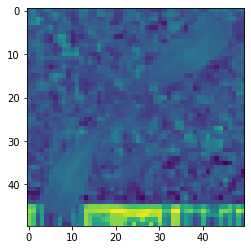

In [18]:
plt.imshow(temp_image)


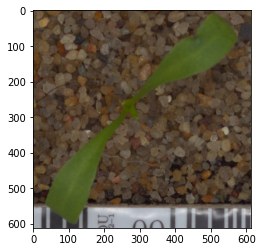

In [19]:
plt.imshow(temp_image2)  ## this is a sample of the original sugarbeet seedling

In [20]:
image_array_Sugarbeet_2=[]  ## We will read in the second set of Sugar beet pictures

for file in os.listdir(data_sugarbeet2):
    path = data_sugarbeet2+'/' +file
    #print(path)
    temp_image = PIL.Image.open(path)
    temp_image = temp_image.resize((50, 50), Image.ANTIALIAS)
    temp_image=ImageOps.grayscale(temp_image)    # Convert to grayscale
    A = np.array(temp_image)            
    #temp_image.show()
    A=A.flatten()
    image_array_Sugarbeet_2.append(A)

In [22]:
image_array_shepherdsPurse=[]  ## We will read in shepherds Purse

for file in os.listdir(data_shepherdsPurse):
    path = data_shepherdsPurse+'/' +file
    #print(path)
    temp_image = PIL.Image.open(path)
    temp_image = temp_image.resize((50, 50), Image.ANTIALIAS)
    temp_image=ImageOps.grayscale(temp_image)    # Convert to grayscale
    A = np.array(temp_image)            
    #temp_image.show()
    A=A.flatten()
    #print('this is flattenned')
    #print(A)
    image_array_shepherdsPurse.append(A)

##  Creating Feature List
### Lets create our column names for the pixels of the image

In [23]:
## Generating feature list.  Need to create fake feature names for each of the pixels of the picture 
## so we can identify the drifts
feature_list=[]
for i in range(1,2501):
  feature_list.append('f'+str(i))


In [24]:
feature_list[1:5]

['f2', 'f3', 'f4', 'f5']

In [25]:
dataframe_1 = pd.DataFrame(image_array_sugarbeet1, columns=feature_list)

In [26]:
dataframe_1a = pd.DataFrame(image_array_Sugarbeet_2, columns=feature_list)

In [27]:
dataframe_2 = pd.DataFrame(image_array_shepherdsPurse, columns=feature_list)

In [28]:
column_list = dataframe_1.columns

In [29]:
dataframe_1.shape


(60, 2500)

In [30]:
dataframe_2.shape

(154, 2500)

In [31]:
dataframe_1a.shape

(144, 2500)

### Evidently Profile
After installing the tool, import Evidently profile and required sections:

In [32]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, NumTargetDriftTab

from evidently.model_profile import Profile
from evidently.profile_sections import DataDriftProfileSection, NumTargetDriftProfileSection

### Functions to clculate drift with Evidently

In [34]:
## this section is taken from Evidently's Github
#evaluate data drift with Evidently Profile
def detect_dataset_drift(reference, production, column_mapping, confidence=0.95, threshold=0.5, get_ratio=False):
    """
    Returns True if Data Drift is detected, else returns False.
    If get_ratio is True, returns ration of drifted features.
    The Data Drift detection depends on the confidence level and the threshold.
    For each individual feature Data Drift is detected with the selected confidence (default value is 0.95).
    Data Drift for the dataset is detected if share of the drifted features is above the selected threshold (default value is 0.5).
    """
    
    data_drift_profile = Profile(sections=[DataDriftProfileSection])
    data_drift_profile.calculate(reference, production, column_mapping=column_mapping)
    report = data_drift_profile.json()
    json_report = json.loads(report)

    drifts = []
    num_features = column_mapping
    cat_features = column_mapping.get('categorical_features') if column_mapping.get('categorical_features') else []
    for feature in num_features :
        drifts.append(json_report['data_drift']['data']['metrics'][feature]['p_value']) 
        
    n_features = len(drifts)
    n_drifted_features = sum([1 if x<(1. - confidence) else 0 for x in drifts])
    
    if get_ratio:
        return n_drifted_features/n_features
    else:
        return True if n_drifted_features/n_features >= threshold else False

In [35]:
## This section is taken from Evidently's Github location
#evaluate data drift with Evidently Profile
def detect_features_drift(reference, production, column_mapping, confidence=0.95, threshold=0.5, get_pvalues=False):
    """
    Returns 1 if Data Drift is detected, else returns 0. 
    If get_pvalues is True, returns p-value for each feature.
    The Data Drift detection depends on the confidence level and the threshold.
    For each individual feature Data Drift is detected with the selected confidence (default value is 0.95).
    """
    
    data_drift_profile = Profile(sections=[DataDriftProfileSection])
    data_drift_profile.calculate(reference, production, column_mapping=column_mapping)
    report = data_drift_profile.json()
    json_report = json.loads(report)
    
    drifts = []
    num_features = column_mapping.get('numerical_features') if column_mapping.get('numerical_features') else []
    cat_features = column_mapping.get('categorical_features') if column_mapping.get('categorical_features') else []
    for feature in num_features + cat_features:
        p_value = json_report['data_drift']['data']['metrics'][feature]['p_value']
        if get_pvalues:
            drifts.append((feature, p_value))
        else:
            drifts.append((feature, True if p_value <(1. - confidence) else False))
             
    return drifts

In [36]:
reference_sets = ('a','b')
experiment_batches = []

In [37]:
#set column mapping for Evidently Profile
data_columns = {}
data_columns['numerical_features'] = feature_list

## Where is the drift?  Visually Detect Features drift

In [40]:
features_historical_drift = []

In [41]:
#for our experiments , the first comparison is between sugarbeet and sugarbeet, where we would expect minimal drifts
drifts = detect_features_drift(dataframe_1, 
              dataframe_1a, 
              column_mapping=data_columns, 
              confidence=0.95,
              threshold=0.9)

features_historical_drift.append([x[1] for x in drifts])

features_historical_drift_frame = pd.DataFrame(features_historical_drift, columns = data_columns['numerical_features'])

In [42]:
features_historical_drift_frame.shape

(1, 2500)

In [43]:
#features_historical_drift_frame.to_excel('drift1.xlsx')

In [44]:
features_historical_drift2 = []

In [45]:
#Second experiment sugar beet with shepherds purse.  Here we expect to see drift in a lot more features
drifts2 = detect_features_drift(dataframe_1, 
              dataframe_2, 
              column_mapping=data_columns, 
              confidence=0.95,
              threshold=0.9)

features_historical_drift2.append([x[1] for x in drifts2])

features_historical_drift_frame2 = pd.DataFrame(features_historical_drift2, columns = data_columns['numerical_features'])

In [ ]:
#features_historical_drift_frame2.to_excel('drift2.xlsx')

In [46]:
drift_filter_array1 = []
drift_filter_array2 = []
for i in range(0,2500):
  drift_filter_array1.append(0)
  drift_filter_array2.append(0)

In [66]:
i=0
for feature in feature_list:
  #print(feature)
  #print(features_historical_drift_frame2[feature][0])
  if features_historical_drift_frame2[feature][0]==True:
    drift_filter_array1[i]= 256
  if features_historical_drift_frame[feature][0]==True:
    drift_filter_array2[i]= 256
  i=i+1
 #  print(feature) 

In [67]:
#type(drift_filter_array)

In [68]:
## change this to a numpy array
drift_filter_array1= np.array(drift_filter_array1)
drift_filter_array2= np.array(drift_filter_array2)

In [69]:
#type(drift_filter_array)

In [70]:
np.reshape(drift_filter_array1,(50,50))

array([[256, 256, 256, ...,   0,   0, 256],
       [256, 256,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 256,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0, 256,   0]])

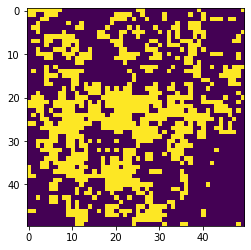

In [71]:
plt.imshow(np.reshape(drift_filter_array1,(50,50)))

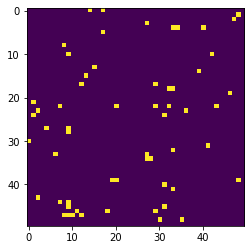

In [72]:
plt.imshow(np.reshape(drift_filter_array2,(50,50)))

In [73]:
rupa_data_drift_dashboard = Dashboard(tabs=[DataDriftTab])
#rupa_data_drift_dashboard.calculate(x_old_dataframe.iloc[1:10], x_old_dataframe.iloc[11:15])
## this is another way to calculate the drift with sections from the same data set
#rupa_data_drift_dashboard.calculate(dataframe_1.iloc[1:80], dataframe_2.iloc[1:22])  
rupa_data_drift_dashboard.calculate(dataframe_1, dataframe_2)

In [ ]:

rupa_data_drift_dashboard.show()

In [ ]:
rupa_data_drift_dashboard.save('/content/drive/My Drive/ModelMonitoringBlog/Rupas_Final_Files/Reports/RG_datadrift_2500_expected_sb_sp_v3.html')

In [ ]:
rupa_data_drift_dashboard.calculate(dataframe_1, dataframe_1a)

In [ ]:
rupa_data_drift_dashboard.save('/content/drive/My Drive/ModelMonitoringBlog/Rupas_Final_Files/Reports/RG_datadrift_2500_no_drift_sb_sb_v3.html')